<a href="https://colab.research.google.com/github/BrunaFerreira/Mestrado_UNIFESP/blob/main/6_Experimentos_Melhores_Seeds_Artigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Bibliotecas a serem utilizadas


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import PIL
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from torchvision import models, transforms
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
pd.options.display.float_format = '{:.2f}'.format
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from PIL import Image
import numpy as np
import os
import torch

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Funções

## Treino do Modelo

In [2]:

def train(model, loader, epochs):
    train_loss_history = []
    train_acc_history = []
    epoch_hist = []
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        train_loss_history.append(avg_loss)
        train_acc_history.append(accuracy)
        epoch_hist.append(epoch+1)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return (epoch_hist, train_loss_history,train_acc_history)

In [3]:
def graf_loss (_model,_loader, n_epocs ):
  start_time = time.time()
  epochs_, loss_train,train_acc = train(_model, _loader, epochs= n_epocs)
  end_time = time.time()
  print(f"Execution Time: {end_time - start_time} seconds")
  plt.figure(figsize=(12, 5))

  # Gráfico de Loss
  plt.plot(epochs_, loss_train, label='Loss', linewidth=3, color = 'red')
  plt.title('Loss and Accuracy per Epoch - VGG16')
  plt.xlabel('Epochs')
  plt.ylabel('Values')
  plt.legend()

  # Gráfico de Acurácia
  #plt.subplot(1, 2, 2)
  plt.plot(epochs_, train_acc, label='Acuracy', linewidth=3, color = 'green')
  plt.title('Loss and Accuracy per Epoch - VGG16')
  plt.xlabel('Epochs')
  plt.ylabel('Values')
  plt.legend()
  plt.tight_layout()
  plt.show()


## Inferencia conjunto de Teste

In [4]:
def inferencia_test(model):

  # Pasta com imagens de teste
  dir_test = os.path.join(dir, "test")

  # Classes: a ordem deve ser a mesma usada durante o treinamento
  # Ex: 0 = 'sem doença', 1 = 'com doença'
  classes = ['0', '1']  # ou ['Negative', 'Positive'], conforme seu label_map

  # Guardar os resultados
  resultados = []

  model.eval()  # Importante: coloca o modelo em modo de avaliação

  with torch.no_grad():
      for nome_arquivo in os.listdir(dir_test):
          if nome_arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
              caminho_imagem = os.path.join(dir_test, nome_arquivo)

              # Abrir imagem e aplicar transform
              imagem = Image.open(caminho_imagem).convert("RGB")
              imagem_tensor = transform(imagem).unsqueeze(0).to(device)

              # Predição
              output = model(imagem_tensor)
              probs = torch.softmax(output, dim=1).cpu().numpy()[0]

              classe_predita = np.argmax(probs)
              conf = probs[classe_predita]

              resultados.append({
                  'arquivo': nome_arquivo,
                  'predicted_label': classes[classe_predita],
                  'probabilidade': round(float(conf), 4)
              })
  return resultados

## Resultado predições Teste

In [5]:
def base_test(resultados):
  test_df = df[df['Base']=='test']
  previsoes  = pd.DataFrame(resultados)
  previsoes.columns = ['Image', 'predicted_label', 'Probability']
  result = pd.merge(test_df, previsoes, on="Image", how="left")
  return result


## Avaliação Modelo

In [6]:
def metricas (df, y_true, y_pred, title_cm):

  auc = roc_auc_score(df[y_true], df[y_pred])
  f1 = f1_score(df[y_true], df[y_pred])
  acuracia = accuracy_score(df[y_true], df[y_pred])
  precision = precision_score(df[y_true], df[y_pred])
  recall = recall_score(df[y_true], df[y_pred])

  return auc*100, f1*100, acuracia*100, precision*100, recall*100

### Matriz de Confusão

In [7]:
def matriz_confusao (df, y_true, y_pred, titulo,arquivo):
  labels = np.unique(df[y_true])
  cm = confusion_matrix(df[y_true], df[y_pred], labels=labels)
  # ==== Transpor para inverter eixos ====
  cm = cm.T  # previsto no eixo Y, real no eixo X
  # ==== Definir nova ordem desejada ====
  if(len(labels)==2):
    order = [1, 0]  # Exemplo: colocar a classe 21 primeiro, depois 0
    ## Reordenar matriz e labels
    cm = cm[order, :]      # reordena linhas
    cm = cm[:, order]      # reordena colunas
    labels = [labels[i] for i in order]
  # ==== Criar vetor de tons de cinza claros ====
  # Valores próximos de 1 = mais claros
  #grey_levels = ["#dcdee0","#c5c7c9", "#a9acb0","#88898a"]
  #custom_cmap = LinearSegmentedColormap.from_list("custom_greys", grey_levels)
  # ==== Plot em escala de cinza ====
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar=False,
              annot_kws={"size": 14},
              xticklabels=['With Sjogren','Without Sjogren'], yticklabels=['With Sjogren','Without Sjogren'])

  plt.xlabel("True Label", fontsize=12)
  plt.ylabel("Predicted Label", fontsize=12)
  plt.title(titulo, fontsize=14)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
    #  Salvar na pasta imgs do Google Drive
  file_path = os.path.join("/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Qualificacao/images/artigo_eniac_2025/"+arquivo+".png")
  plt.savefig(file_path, dpi=300, bbox_inches="tight")
  plt.show()

## Resultado Final

In [9]:
def resultado_final (result, modelo):
  df_fairness  = pd.DataFrame()
  result['Label_pSS'] = result['Label_pSS'].astype(int)
  result['predicted_label'] = result['predicted_label'].astype(int)

  df_fairness['Full Dataset'] = metricas (result, "Label_pSS", "predicted_label", 'Confusion Matrix - Full Test Dataset')
  matriz_confusao (result, "Label_pSS", "predicted_label","Confusion Matrix - Full Dataset", modelo+"_Confusion_Matrix_Full_Dataset")

  ## Métricas Idade
  df_age_ate40 = result[result['Faixa_Etaria']=='Under 40']
  df_fairness['Age <= 40 years'] = metricas (df_age_ate40, "Label_pSS", "predicted_label", 'Confusion Matrix - Under 40 years')
  matriz_confusao (df_age_ate40, "Label_pSS", "predicted_label","Confusion Matrix - Under 40 years", modelo+"_Confusion_Matrix_Age_Under40")

  df_age_mais40 = result[result['Faixa_Etaria']=='Above 40']
  df_fairness['Age > 40 years'] = metricas (df_age_mais40, "Label_pSS", "predicted_label", 'Confusion Matrix - Above 40 years')
  matriz_confusao (df_age_mais40, "Label_pSS", "predicted_label","Confusion Matrix - Above 40 years", modelo+"_Confusion_Matrix_Age_Above40")

  print("Test:",result.shape[0])
  print("df_age_ate40:",df_age_ate40.shape[0])
  print("df_age_ate40:",df_age_mais40.shape[0])
  print("Age:",df_age_mais40.shape[0] + df_age_ate40.shape[0])

  ## Métricas Sex
  df_sex_F = result[result['Sex']== 'F']
  df_fairness['Female'] = metricas (df_sex_F, "Label_pSS", "predicted_label", 'Confusion Matrix - Female Sex')
  matriz_confusao (df_sex_F, "Label_pSS", "predicted_label","Confusion Matrix - Female Sex", modelo+"_Confusion_Matrix_Sex_F")

  df_sex_M = result[result['Sex']== 'M']
  df_fairness['Male'] = metricas (df_sex_M, "Label_pSS", "predicted_label", 'Confusion Matrix - Male Sex')
  matriz_confusao (df_sex_M, "Label_pSS", "predicted_label","Confusion Matrix - Male Sex", modelo+"_Confusion_Matrix_Sex_M")

  print("\ndf_sex_F:",df_sex_F.shape[0])
  print("df_sex_M:",df_sex_M.shape[0])
  print("Sexo:",df_sex_F.shape[0] + df_sex_M.shape[0])

  return df_fairness

# 2. Leitura dos dados (imagens de glandulas salivares)

In [10]:
df = pd.read_csv('/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/files_csv/HarmonicSS_Split_V5.csv')
dir = '/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/dataset'
df.head()

,ID,Sex,Faixa_Etaria,Label_pSS,Image,Base
0,1,F,Above 40,1,001.jpg,train
1,2,F,Above 40,1,002.jpg,test
2,3,F,Above 40,0,003.jpg,train
3,4,F,Above 40,0,004.jpg,train
4,5,F,Above 40,0,005.jpg,train


In [11]:
df[df['Base']=='test'].shape

(68, 6)

### Pre Processar imagens

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = ImageFolder(dir + '/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Modelo VGG

Classifier do VGG16. O VGG16 tem três camadas lineares na cabeça (classifier), e a camada [1] não é a de saída final. A correta é [6].

## Seed 0

In [13]:
 print("Modelo: VGG \nSeed: 0")
 # ==== 0. Definir seed para reprodutibilidade ====
 seed = 0
 random.seed(seed)
 np.random.seed(seed)
 torch.manual_seed(seed)
 torch.cuda.manual_seed(seed)
 torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False
 # ==== 1. Carregar VGG16 pré-treinado ====
 model_vgg = models.vgg16(pretrained=True)
 # ==== 2. Adaptar a última camada ====
 num_classes = 2
 model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)
 # ==== 3. Preparar os rótulos ====
 y = torch.tensor(df['Label_pSS'].values)  # garante que é um tensor e não série diretamente
 # ==== 4. Calcular pesos de classe ====
 class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
 class_weights = torch.tensor(class_weights, dtype=torch.float)
 # ==== 5. Configurar dispositivo, modelo, loss e otimizador ====
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 model_vgg = model_vgg.to(device)
 criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
 optimizer = optim.Adam(model_vgg.parameters(), lr=1e-4)

Modelo: VGG 
Seed: 0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 0.8623, Accuracy: 0.7628
Epoch [2/50], Loss: 0.6160, Accuracy: 0.7821
Epoch [3/50], Loss: 0.4690, Accuracy: 0.7051
Epoch [4/50], Loss: 0.4626, Accuracy: 0.8333
Epoch [5/50], Loss: 0.3600, Accuracy: 0.8782
Epoch [6/50], Loss: 0.1881, Accuracy: 0.9615
Epoch [7/50], Loss: 0.1211, Accuracy: 0.9872
Epoch [8/50], Loss: 0.0563, Accuracy: 0.9808
Epoch [9/50], Loss: 0.0286, Accuracy: 1.0000
Epoch [10/50], Loss: 0.0470, Accuracy: 0.9936
Epoch [11/50], Loss: 0.1873, Accuracy: 0.9551
Epoch [12/50], Loss: 0.2250, Accuracy: 0.9423
Epoch [13/50], Loss: 0.1664, Accuracy: 0.9359
Epoch [14/50], Loss: 0.2257, Accuracy: 0.9615
Epoch [15/50], Loss: 0.2152, Accuracy: 0.9038
Epoch [16/50], Loss: 0.0230, Accuracy: 0.9936
Epoch [17/50], Loss: 0.0714, Accuracy: 0.9872
Epoch [18/50], Loss: 0.0396, Accuracy: 0.9872
Epoch [19/50], Loss: 0.0398, Accuracy: 0.9936
Epoch [20/50], Loss: 0.0505, Accuracy: 0.9679
Epoch [21/50], Loss: 0.2393, Accuracy: 0.9808
Epoch [22/50], Loss: 0.2084, Accuracy: 0.91

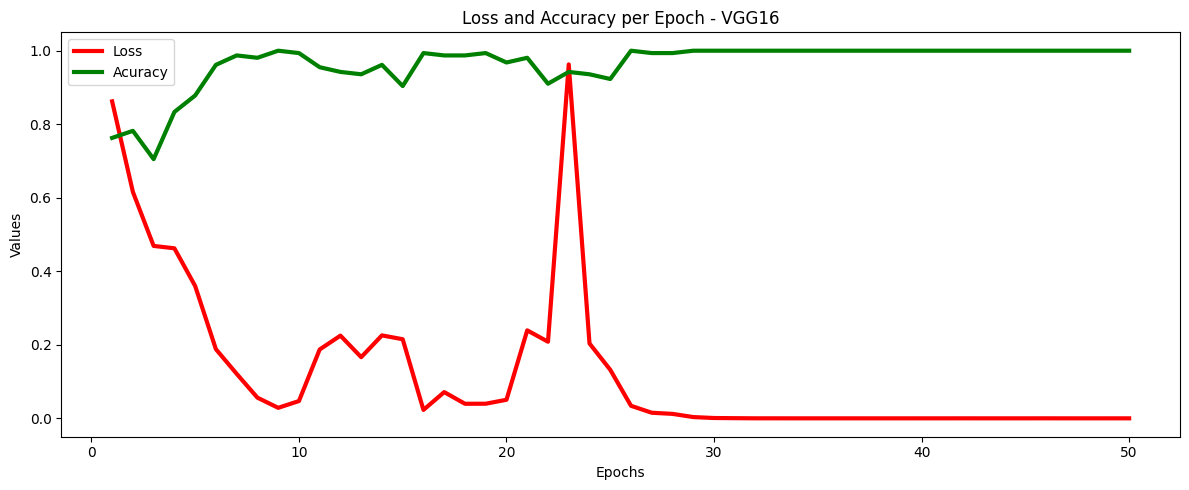

In [14]:
graf_loss (model_vgg,train_loader, 50)
resultados_vgg = inferencia_test(model_vgg)
result_vgg = base_test(resultados_vgg)

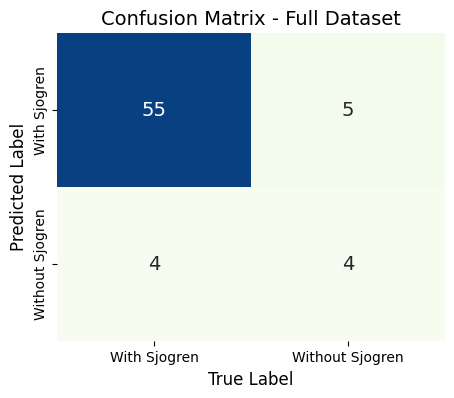

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


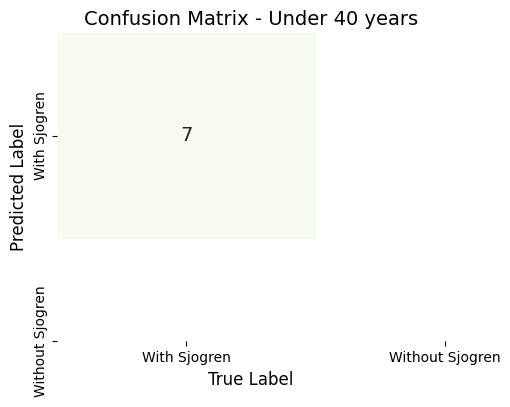

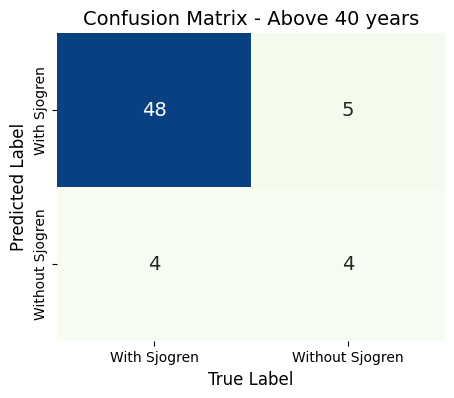

Test: 68
df_age_ate40: 7
df_age_ate40: 61
Age: 68


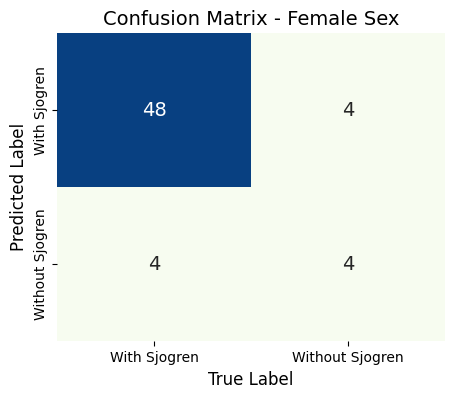

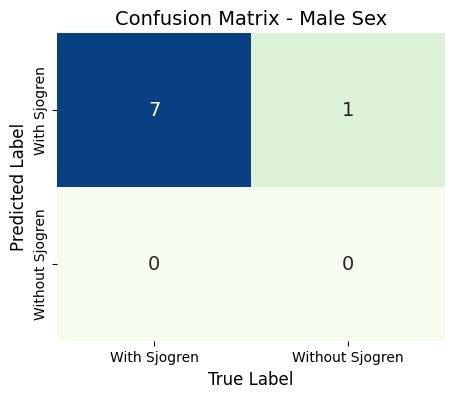


df_sex_F: 60
df_sex_M: 8
Sexo: 68


In [15]:
df_fairness_vgg = resultado_final(result_vgg,'VGG')

In [16]:
df_fairness_vgg

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
0,68.83,NaN,68.38,71.15,50.00
1,92.44,100.00,91.43,92.31,93.33
2,86.76,100.00,85.25,86.67,87.50
3,91.67,100.00,90.57,92.31,87.50
4,93.22,100.00,92.31,92.31,100.00


# Modelo Resnet

## Seed 5

In [17]:
# ==== 0. Definir seed para reprodutibilidade ====
seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ==== 1. Carregar ResNet50 pré-treinado ====
model_resnet = models.resnet50(pretrained=True)

# ==== 2. Adaptar a última camada ====
num_classes = 2
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)

# ==== 3. Preparar os rótulos ====
y = torch.tensor(df['Label_pSS'].values)

# ==== 4. Calcular pesos de classe ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ==== 5. Configurar dispositivo, loss e otimizador ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


Epoch [1/50], Loss: 0.6388, Accuracy: 0.4808
Epoch [2/50], Loss: 0.2924, Accuracy: 0.9103
Epoch [3/50], Loss: 0.1151, Accuracy: 1.0000
Epoch [4/50], Loss: 0.0366, Accuracy: 1.0000
Epoch [5/50], Loss: 0.0154, Accuracy: 1.0000
Epoch [6/50], Loss: 0.0090, Accuracy: 1.0000
Epoch [7/50], Loss: 0.0081, Accuracy: 1.0000
Epoch [8/50], Loss: 0.0028, Accuracy: 1.0000
Epoch [9/50], Loss: 0.0055, Accuracy: 1.0000
Epoch [10/50], Loss: 0.0020, Accuracy: 1.0000
Epoch [11/50], Loss: 0.0051, Accuracy: 1.0000
Epoch [12/50], Loss: 0.0304, Accuracy: 0.9872
Epoch [13/50], Loss: 0.0041, Accuracy: 1.0000
Epoch [14/50], Loss: 0.0063, Accuracy: 1.0000
Epoch [15/50], Loss: 0.0040, Accuracy: 1.0000
Epoch [16/50], Loss: 0.0051, Accuracy: 1.0000
Epoch [17/50], Loss: 0.0017, Accuracy: 1.0000
Epoch [18/50], Loss: 0.0040, Accuracy: 1.0000
Epoch [19/50], Loss: 0.0037, Accuracy: 1.0000
Epoch [20/50], Loss: 0.0056, Accuracy: 1.0000
Epoch [21/50], Loss: 0.0061, Accuracy: 1.0000
Epoch [22/50], Loss: 0.0021, Accuracy: 1.00

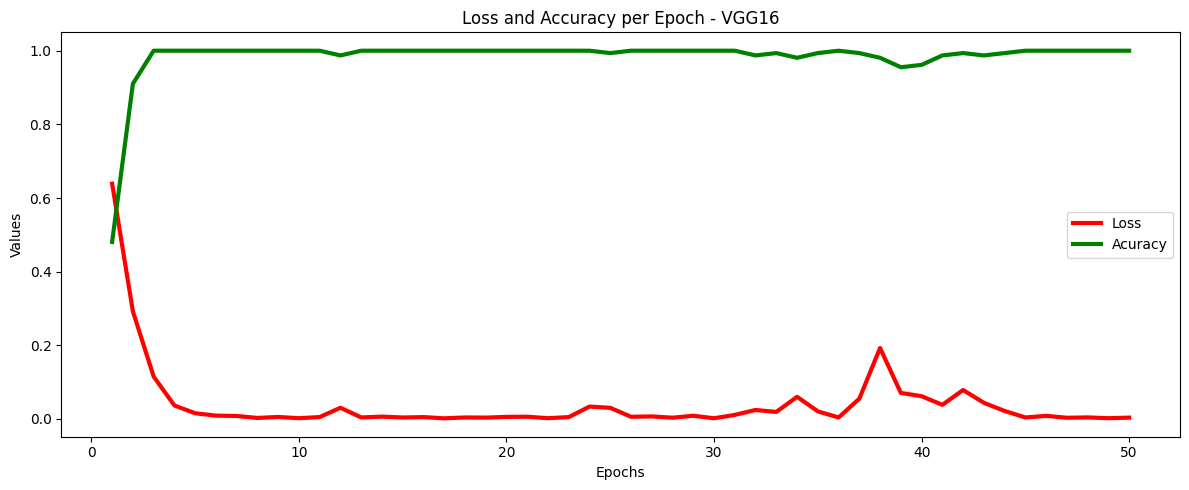

In [18]:
graf_loss (model_resnet,train_loader, 50)
resultados_resnet = inferencia_test(model_resnet)
result_resnet = base_test(resultados_resnet)

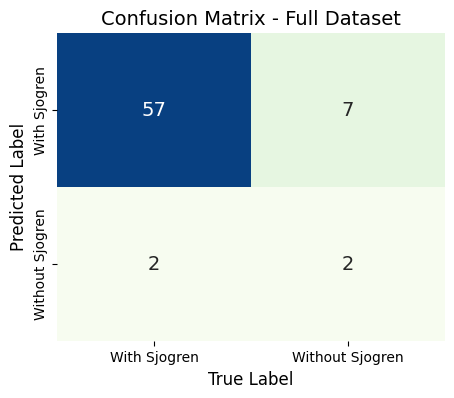

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


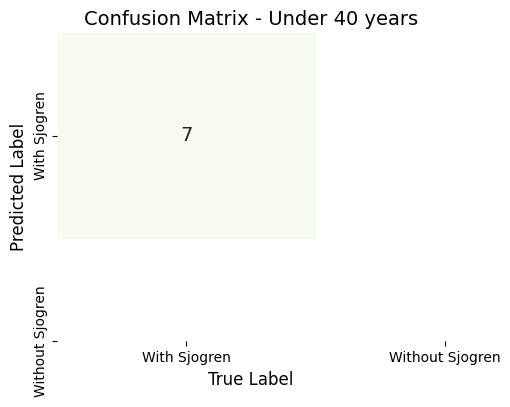

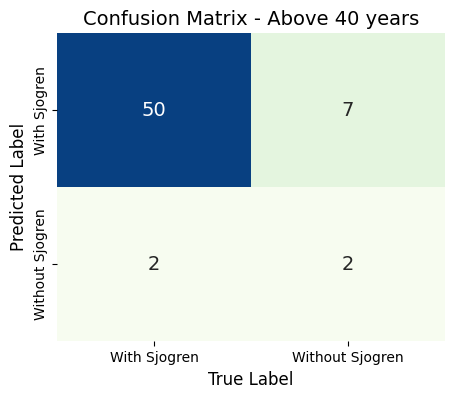

Test: 68
df_age_ate40: 7
df_age_ate40: 61
Age: 68


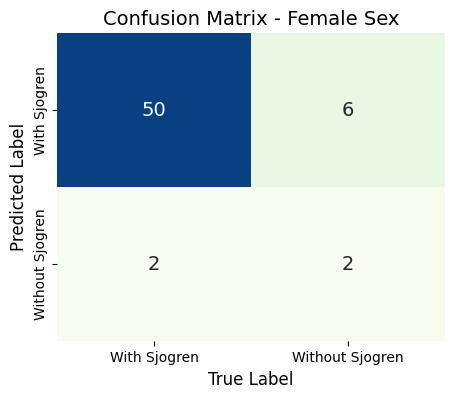

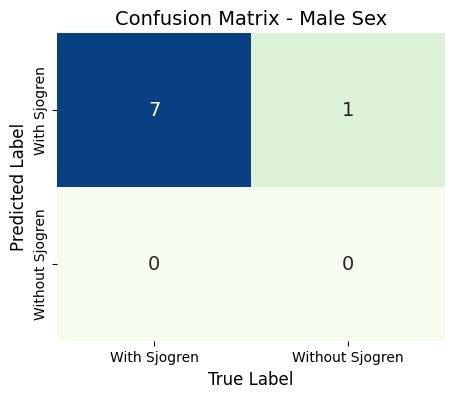


df_sex_F: 60
df_sex_M: 8
Sexo: 68


In [19]:
df_fairness_resnet = resultado_final(result_resnet,'Resnet')

In [20]:
df_fairness_resnet

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
0,59.42,NaN,59.19,60.58,50.00
1,92.68,100.00,91.74,92.59,93.33
2,86.76,100.00,85.25,86.67,87.50
3,89.06,100.00,87.72,89.29,87.50
4,96.61,100.00,96.15,96.15,100.00


#Modelo Efficient

## Seed 42

In [21]:
# ==== 0. Definir seed para reprodutibilidade ====
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ==== 1. Carregar EfficientNet-B0 pré-treinado ====
model_efficient = models.efficientnet_b0(pretrained=True)

# ==== 2. Adaptar a última camada ====
num_classes = 2
model_efficient.classifier[1] = nn.Linear(model_efficient.classifier[1].in_features, num_classes)

# ==== 3. Preparar os rótulos ====
y = torch.tensor(df['Label_pSS'].values)

# ==== 4. Calcular pesos de classe ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ==== 5. Configurar dispositivo, loss e otimizador ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efficient = model_efficient.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model_efficient.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 120MB/s]


Epoch [1/50], Loss: 0.7225, Accuracy: 0.3397
Epoch [2/50], Loss: 0.5714, Accuracy: 0.5769
Epoch [3/50], Loss: 0.4861, Accuracy: 0.7372
Epoch [4/50], Loss: 0.4167, Accuracy: 0.8013
Epoch [5/50], Loss: 0.3315, Accuracy: 0.8654
Epoch [6/50], Loss: 0.2899, Accuracy: 0.9103
Epoch [7/50], Loss: 0.2727, Accuracy: 0.9359
Epoch [8/50], Loss: 0.1902, Accuracy: 0.9808
Epoch [9/50], Loss: 0.1762, Accuracy: 0.9808
Epoch [10/50], Loss: 0.1279, Accuracy: 0.9872
Epoch [11/50], Loss: 0.0956, Accuracy: 1.0000
Epoch [12/50], Loss: 0.0744, Accuracy: 1.0000
Epoch [13/50], Loss: 0.1009, Accuracy: 0.9936
Epoch [14/50], Loss: 0.0717, Accuracy: 0.9936
Epoch [15/50], Loss: 0.0569, Accuracy: 0.9936
Epoch [16/50], Loss: 0.0410, Accuracy: 1.0000
Epoch [17/50], Loss: 0.0509, Accuracy: 1.0000
Epoch [18/50], Loss: 0.0244, Accuracy: 1.0000
Epoch [19/50], Loss: 0.0257, Accuracy: 1.0000
Epoch [20/50], Loss: 0.0226, Accuracy: 1.0000
Epoch [21/50], Loss: 0.0348, Accuracy: 0.9936
Epoch [22/50], Loss: 0.0200, Accuracy: 1.00

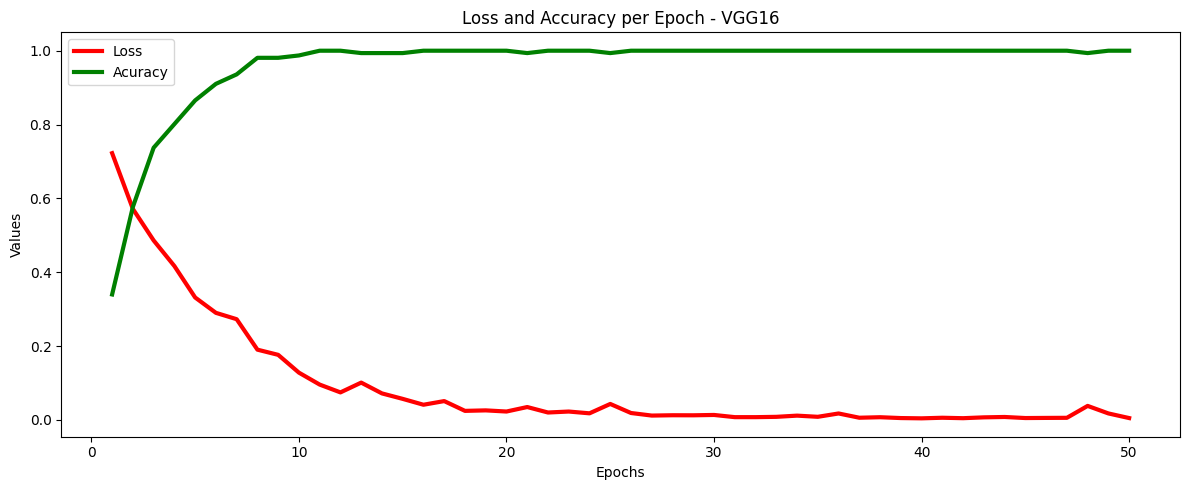

In [22]:
graf_loss (model_efficient,train_loader, 50)
resultados_efficient = inferencia_test(model_efficient)
result_efficient = base_test(resultados_efficient)

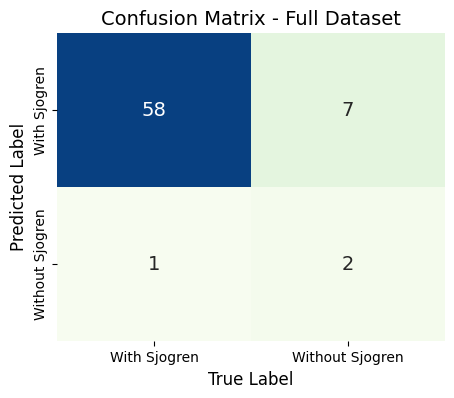

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


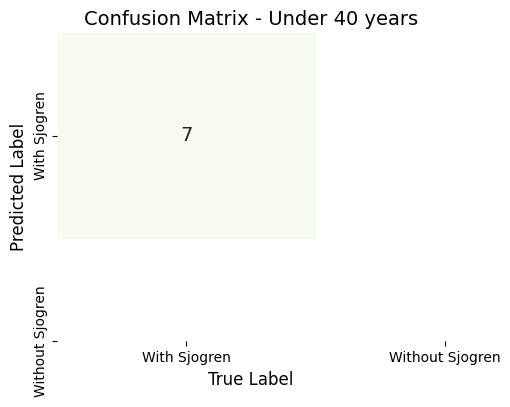

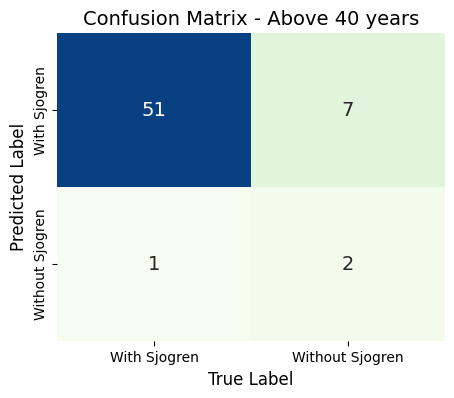

Test: 68
df_age_ate40: 7
df_age_ate40: 61
Age: 68


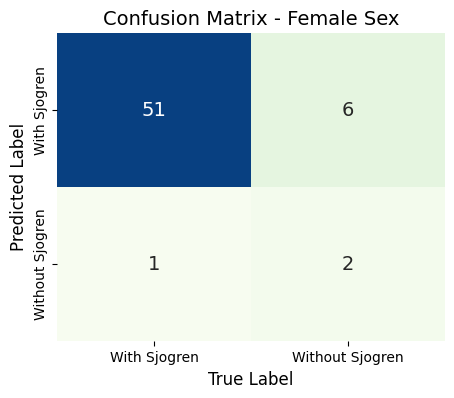

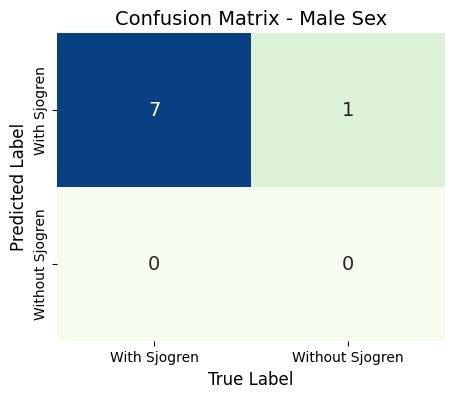


df_sex_F: 60
df_sex_M: 8
Sexo: 68


In [23]:
df_fairness_efficient = resultado_final(result_efficient, 'Efficient')

In [24]:
df_fairness_efficient

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
0,60.26,NaN,60.15,61.54,50.00
1,93.55,100.00,92.73,93.58,93.33
2,88.24,100.00,86.89,88.33,87.50
3,89.23,100.00,87.93,89.47,87.50
4,98.31,100.00,98.08,98.08,100.00


# Modelo RadImagenet

## Seed 5

In [25]:
import torch
import torch.nn as nn
from torchvision import models

# ==== 0. Definir seed para reprodutibilidade ====
seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ==== 1. Carregar arquitetura ResNet50 ====
model_rad = models.resnet50(pretrained=False)
model_rad.fc = nn.Linear(model_rad.fc.in_features, 2)

# ==== 2. Carregar checkpoint do RadImageNet ====
checkpoint_path = "/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/files_pth/ResNet50.pt"
checkpoint = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu")

# ==== 3. Extrair e limpar state_dict ====
state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint
clean_state_dict = {k.replace("module.", "").replace("model_rad.", ""): v for k, v in state_dict.items()}
model_rad.load_state_dict(clean_state_dict, strict=False)

# ==== 4. Enviar modelo para dispositivo ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rad = model_rad.to(device)
model_rad.eval()

# ==== 5. Preparar os rótulos ====
y = torch.tensor(df['Label_pSS'].values)

# ==== 6. Calcular pesos de classe ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ==== 7. Definir função de perda e otimizador ====
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_rad.parameters()), lr=1e-4)

print("✅ Modelo ResNet50 com pesos RadImageNet carregado e configurado com sucesso!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Modelo ResNet50 com pesos RadImageNet carregado e configurado com sucesso!


Epoch [1/50], Loss: 0.7061, Accuracy: 0.6154
Epoch [2/50], Loss: 0.5525, Accuracy: 0.8077
Epoch [3/50], Loss: 0.4824, Accuracy: 0.8013
Epoch [4/50], Loss: 0.4321, Accuracy: 0.7949
Epoch [5/50], Loss: 0.3964, Accuracy: 0.8782
Epoch [6/50], Loss: 0.3257, Accuracy: 0.9167
Epoch [7/50], Loss: 0.2340, Accuracy: 0.9615
Epoch [8/50], Loss: 0.1870, Accuracy: 0.9679
Epoch [9/50], Loss: 0.2080, Accuracy: 0.9423
Epoch [10/50], Loss: 0.1288, Accuracy: 0.9551
Epoch [11/50], Loss: 0.1416, Accuracy: 0.9744
Epoch [12/50], Loss: 0.0965, Accuracy: 0.9872
Epoch [13/50], Loss: 0.0625, Accuracy: 0.9936
Epoch [14/50], Loss: 0.0669, Accuracy: 0.9808
Epoch [15/50], Loss: 0.0513, Accuracy: 0.9808
Epoch [16/50], Loss: 0.0969, Accuracy: 0.9808
Epoch [17/50], Loss: 0.0759, Accuracy: 0.9872
Epoch [18/50], Loss: 0.2392, Accuracy: 0.9231
Epoch [19/50], Loss: 0.0869, Accuracy: 0.9487
Epoch [20/50], Loss: 0.0916, Accuracy: 0.9744
Epoch [21/50], Loss: 0.0922, Accuracy: 0.9744
Epoch [22/50], Loss: 0.0460, Accuracy: 0.98

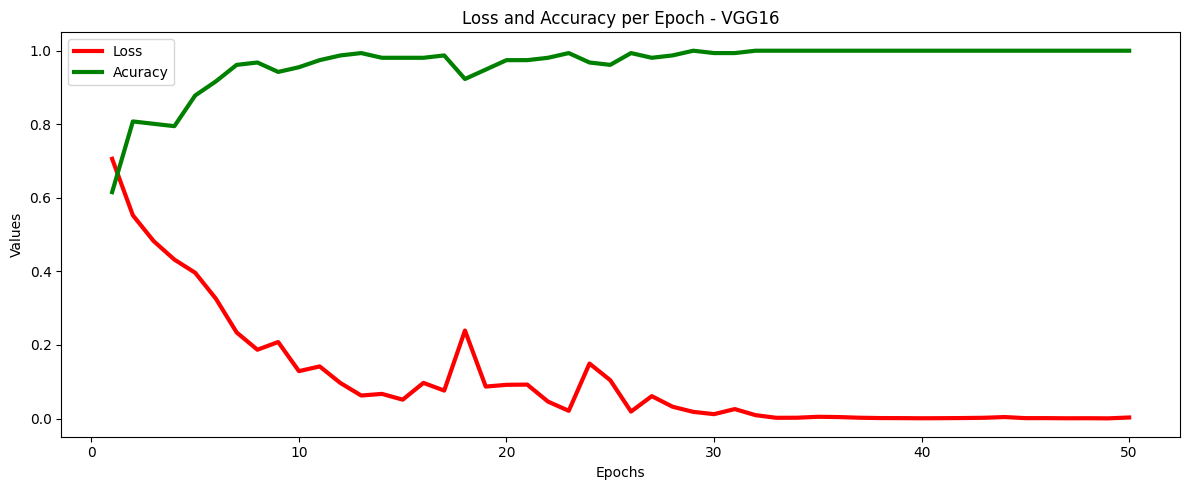

In [26]:
graf_loss (model_rad,train_loader, 50)
resultados_rad = inferencia_test(model_rad)
result_rad = base_test(resultados_rad)

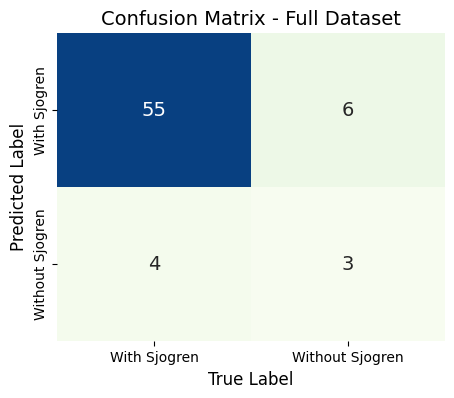

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


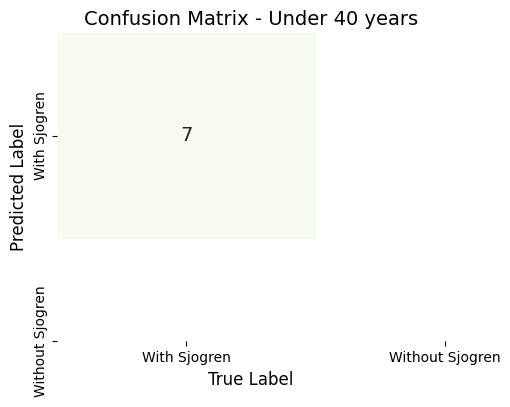

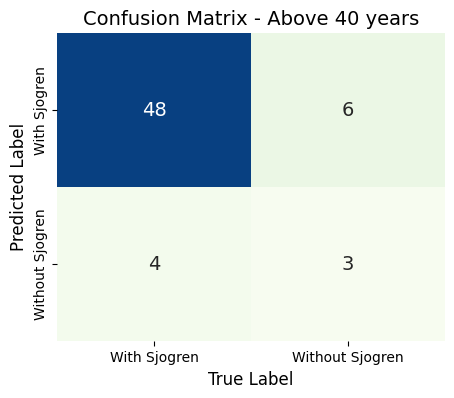

Test: 68
df_age_ate40: 7
df_age_ate40: 61
Age: 68


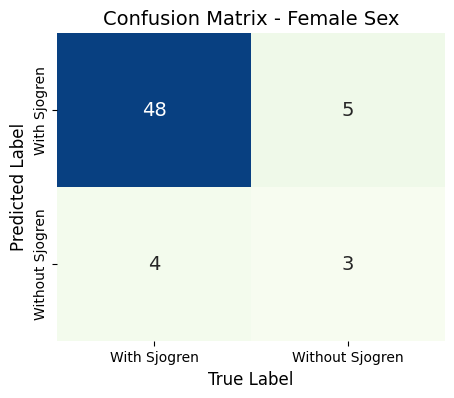

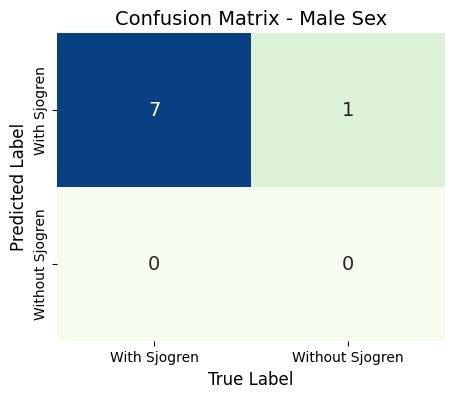


df_sex_F: 60
df_sex_M: 8
Sexo: 68


In [27]:
df_fairness_rad = resultado_final(result_rad,'RadImageNet')

In [28]:
df_fairness_rad

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
0,63.28,NaN,62.82,64.90,50.00
1,91.67,100.00,90.57,91.43,93.33
2,85.29,100.00,83.61,85.00,87.50
3,90.16,100.00,88.89,90.57,87.50
4,93.22,100.00,92.31,92.31,100.00


# Modelo CNN

## Seed 3

In [29]:
# ==== 0. Definir seed para reprodutibilidade ====
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ==== 1. Definir uma CNN simples ====
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Para entrada 224x224
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # -> (B, 16, 112, 112)
        x = self.pool(torch.relu(self.conv2(x)))  # -> (B, 32, 56, 56)
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==== 2. Instanciar o modelo ====
num_classes = 2
model_CNN = SimpleCNN(num_classes=num_classes)

# ==== 3. Preparar os rótulos ====
y = torch.tensor(df['Label_pSS'].values)

# ==== 4. Calcular pesos de classe ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ==== 5. Configurar dispositivo, loss e otimizador ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN = model_CNN.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model_CNN.parameters(), lr=1e-4)

Epoch [1/50], Loss: 1.1781, Accuracy: 0.7179
Epoch [2/50], Loss: 0.8116, Accuracy: 0.2500
Epoch [3/50], Loss: 0.8325, Accuracy: 0.8654
Epoch [4/50], Loss: 0.7731, Accuracy: 0.2628
Epoch [5/50], Loss: 0.6021, Accuracy: 0.6923
Epoch [6/50], Loss: 0.5816, Accuracy: 0.8974
Epoch [7/50], Loss: 0.5127, Accuracy: 0.7949
Epoch [8/50], Loss: 0.4390, Accuracy: 0.8462
Epoch [9/50], Loss: 0.4960, Accuracy: 0.9359
Epoch [10/50], Loss: 0.4037, Accuracy: 0.8910
Epoch [11/50], Loss: 0.3880, Accuracy: 0.7949
Epoch [12/50], Loss: 0.3309, Accuracy: 0.9423
Epoch [13/50], Loss: 0.3110, Accuracy: 0.9231
Epoch [14/50], Loss: 0.2936, Accuracy: 0.9359
Epoch [15/50], Loss: 0.2538, Accuracy: 0.9167
Epoch [16/50], Loss: 0.2443, Accuracy: 0.9295
Epoch [17/50], Loss: 0.2112, Accuracy: 0.9872
Epoch [18/50], Loss: 0.2369, Accuracy: 0.8910
Epoch [19/50], Loss: 0.2065, Accuracy: 0.9744
Epoch [20/50], Loss: 0.1554, Accuracy: 0.9936
Epoch [21/50], Loss: 0.1557, Accuracy: 0.9423
Epoch [22/50], Loss: 0.1272, Accuracy: 1.00

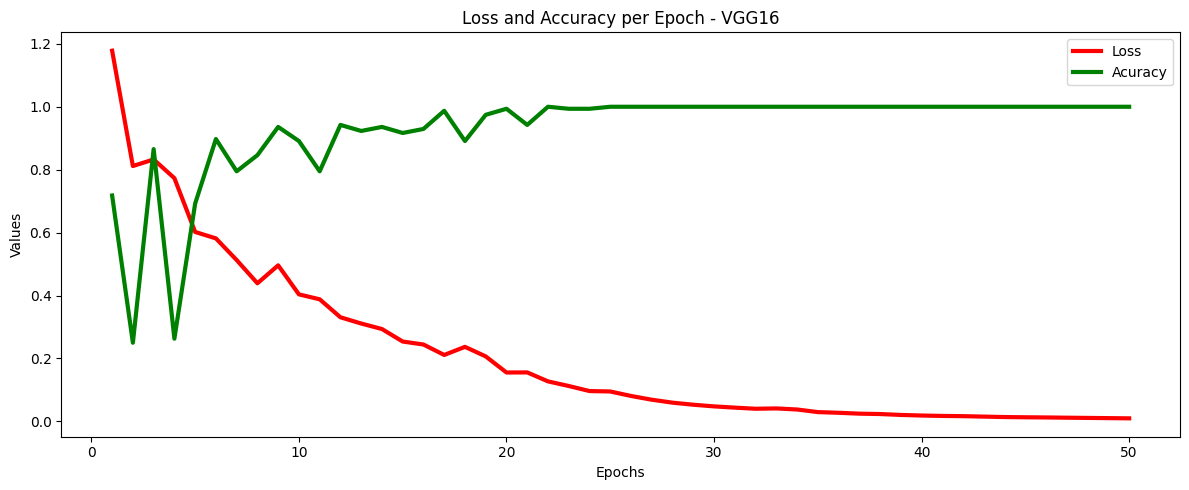

In [30]:
graf_loss (model_CNN,train_loader, 50)
resultados_CNN = inferencia_test(model_CNN)
result_CNN = base_test(resultados_CNN)

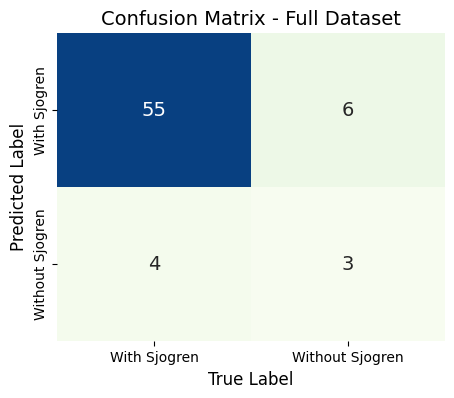

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


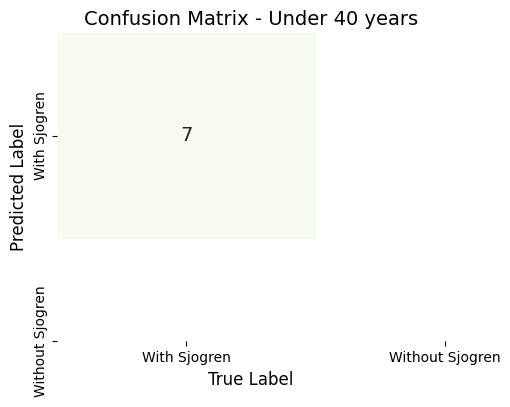

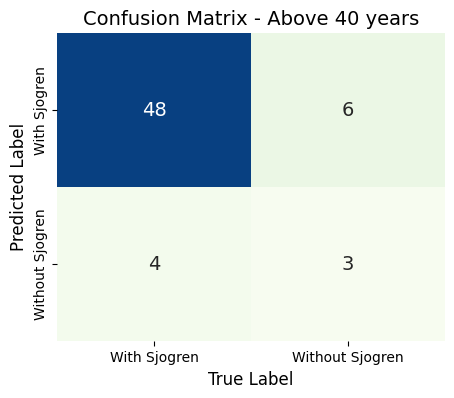

Test: 68
df_age_ate40: 7
df_age_ate40: 61
Age: 68


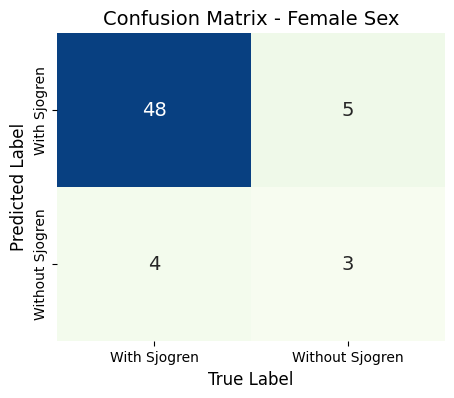

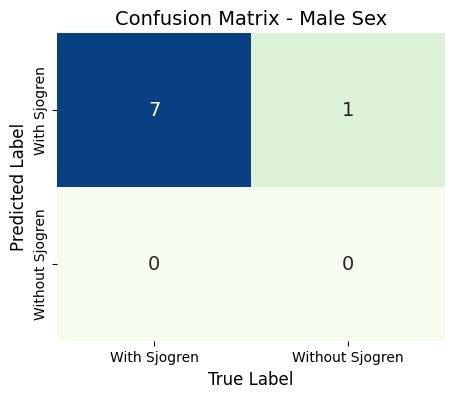


df_sex_F: 60
df_sex_M: 8
Sexo: 68


In [31]:
df_fairness_CNN = resultado_final(result_CNN,'CNN')

In [32]:
df_fairness_CNN

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
0,63.28,NaN,62.82,64.90,50.00
1,91.67,100.00,90.57,91.43,93.33
2,85.29,100.00,83.61,85.00,87.50
3,90.16,100.00,88.89,90.57,87.50
4,93.22,100.00,92.31,92.31,100.00
